# Fitting with time delay scan (model: sum of exponential decay and damped oscillation)
## Objective
1. Fitting with sum of exponential decay model and damped oscillation model
2. Save and Load fitting result
3. Calculates species associated coefficent from fitting result
4. Evaluates F-test based confidence interval


In this example, we only deal with gaussian irf 

In [24]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_seq_model, rate_eq_conv, dmp_osc_conv_gau 
plt.rcParams["figure.figsize"] = (12,9)

## Version information

In [25]:
print(TRXASprefitpack.__version__)

0.7.0


## Detecting oscillation feature

In [26]:
# Generates fake experiment data
# Model: 1 -> 2 -> 3 -> GS
# lifetime tau1: 500 fs, tau2: 10 ps, tau3: 1000 ps
# oscillation: tau_osc: 1 ps, period_osc: 300 fs, phase: pi/4
# fwhm paramter of gaussian IRF: 100 fs

tau_1 = 0.5
tau_2 = 10
tau_3 = 1000
fwhm = 0.100
tau_osc = 1
period_osc = 0.3
phase = np.pi/4

# initial condition
y0 = np.array([1, 0, 0, 0])

# set time range (mixed step)
t_seq1 = np.arange(-2, -1, 0.2)
t_seq2 = np.arange(-1, 2, 0.02)
t_seq3 = np.arange(2, 5, 0.2)
t_seq4 = np.arange(5, 10, 1)
t_seq5 = np.arange(10, 100, 10)
t_seq6 = np.arange(100, 1000, 100)
t_seq7 = np.linspace(1000, 2000, 2)

t_seq = np.hstack((t_seq1, t_seq2, t_seq3, t_seq4, t_seq5, t_seq6, t_seq7))

eigval_seq, V_seq, c_seq = solve_seq_model(np.array([tau_1, tau_2, tau_3]), y0)

# Now generates measured transient signal
# Last element is ground state

abs_1 = [1, 1, 1, 0]; abs_1_osc = 0.05
abs_2 = [0.5, 0.8, 0.2, 0]; abs_2_osc = 0.001
abs_3 = [-0.5, 0.7, 0.9, 0]; abs_3_osc = -0.002
abs_4 = [0.6, 0.3, -1, 0]; abs_4_osc = 0.0018

t0 = np.random.normal(0, fwhm, 4) # perturb time zero of each scan

# generate measured data

y_obs_1 = rate_eq_conv(t_seq-t0[0], fwhm, abs_1, eigval_seq, V_seq, c_seq, irf='g')+\
    abs_1_osc*dmp_osc_conv_gau(t_seq-t0[0], fwhm, 1/tau_osc, period_osc, phase)
y_obs_2 = rate_eq_conv(t_seq-t0[1], fwhm, abs_2, eigval_seq, V_seq, c_seq, irf='g')+\
    abs_2_osc*dmp_osc_conv_gau(t_seq-t0[1], fwhm, 1/tau_osc, period_osc, phase)
y_obs_3 = rate_eq_conv(t_seq-t0[2], fwhm, abs_3, eigval_seq, V_seq, c_seq, irf='g')+\
    abs_3_osc*dmp_osc_conv_gau(t_seq-t0[2], fwhm, 1/tau_osc, period_osc, phase)
y_obs_4 = rate_eq_conv(t_seq-t0[3], fwhm, abs_4, eigval_seq, V_seq, c_seq, irf='g')+\
    abs_4_osc*dmp_osc_conv_gau(t_seq-t0[3], fwhm, 1/tau_osc, period_osc, phase)

# generate random noise with (S/N = 200)

# Define noise level (S/N=200) w.r.t peak
eps_obs_1 = np.max(np.abs(y_obs_1))/200*np.ones_like(y_obs_1)
eps_obs_2 = np.max(np.abs(y_obs_2))/200*np.ones_like(y_obs_2)
eps_obs_3 = np.max(np.abs(y_obs_3))/200*np.ones_like(y_obs_3)
eps_obs_4 = np.max(np.abs(y_obs_4))/200*np.ones_like(y_obs_4)

# generate random noise
noise_1 = np.random.normal(0, eps_obs_1, t_seq.size)
noise_2 = np.random.normal(0, eps_obs_2, t_seq.size)
noise_3 = np.random.normal(0, eps_obs_3, t_seq.size)
noise_4 = np.random.normal(0, eps_obs_4, t_seq.size)


# generate measured intensity
i_obs_1 = y_obs_1 + noise_1
i_obs_2 = y_obs_2 + noise_2
i_obs_3 = y_obs_3 + noise_3
i_obs_4 = y_obs_4 + noise_4

# print real values

print('-'*24)
print(f'fwhm: {fwhm}')
print(f'tau_1: {tau_1}')
print(f'tau_2: {tau_2}')
print(f'tau_3: {tau_3}')
print(f'tau_osc: {tau_osc}')
print(f'period_osc: {period_osc}')
print(f'phase_osc: {phase}')
for i in range(4):
    print(f't_0_{i+1}: {t0[i]}')
print('-'*24)
print('Excited Species contribution')
print(f'scan 1: {abs_1[0]} \t {abs_1[1]} \t {abs_1[2]}')
print(f'scan 2: {abs_2[0]} \t {abs_2[1]} \t {abs_2[2]}')
print(f'scan 3: {abs_3[0]} \t {abs_3[1]} \t {abs_3[2]}')
print(f'scan 4: {abs_4[0]} \t {abs_4[1]} \t {abs_4[2]}')

param_exact = [fwhm, t0[0], t0[1], t0[2], t0[3], tau_1, tau_2, tau_3, tau_osc, period_osc, phase]

data1 = np.vstack((t_seq, i_obs_1, eps_obs_1)).T
data2 = np.vstack((t_seq, i_obs_2, eps_obs_2)).T
data3 = np.vstack((t_seq, i_obs_3, eps_obs_3)).T
data4 = np.vstack((t_seq, i_obs_4, eps_obs_4)).T

------------------------
fwhm: 0.1
tau_1: 0.5
tau_2: 10
tau_3: 1000
tau_osc: 1
period_osc: 0.3
phase_osc: 0.7853981633974483
t_0_1: -0.004960794315238031
t_0_2: 0.15689212316332068
t_0_3: -0.05307330175122729
t_0_4: -0.045460069698502054
------------------------
Excited Species contribution
scan 1: 1 	 1 	 1
scan 2: 0.5 	 0.8 	 0.2
scan 3: -0.5 	 0.7 	 0.9
scan 4: 0.6 	 0.3 	 -1


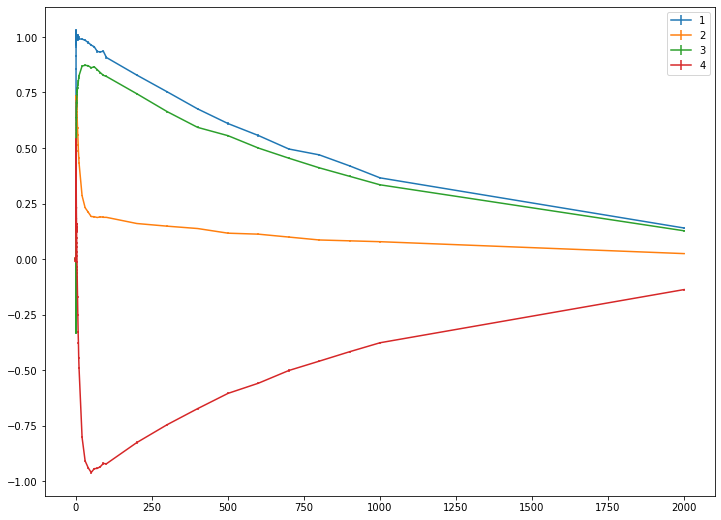

In [27]:
# plot model experimental data

plt.errorbar(t_seq, i_obs_1, eps_obs_1, label='1')
plt.errorbar(t_seq, i_obs_2, eps_obs_2, label='2')
plt.errorbar(t_seq, i_obs_3, eps_obs_3, label='3')
plt.errorbar(t_seq, i_obs_4, eps_obs_4, label='4')
plt.legend()
plt.show()

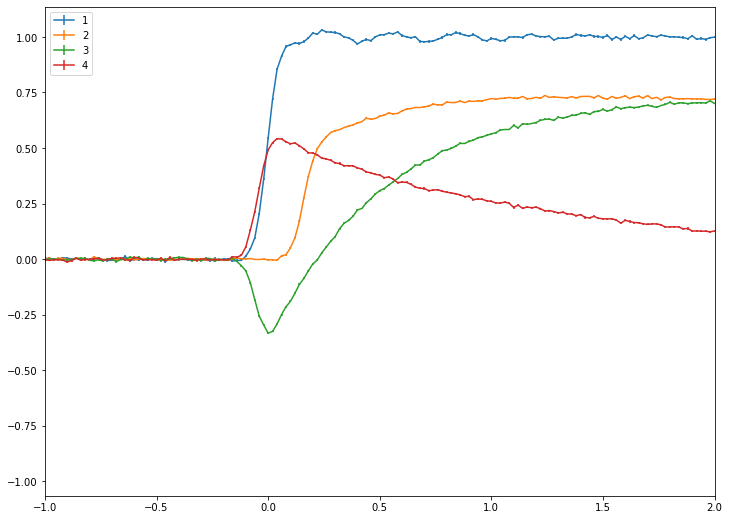

In [28]:
plt.errorbar(t_seq, i_obs_1, eps_obs_1, label='1')
plt.errorbar(t_seq, i_obs_2, eps_obs_2, label='2')
plt.errorbar(t_seq, i_obs_3, eps_obs_3, label='3')
plt.errorbar(t_seq, i_obs_4, eps_obs_4, label='4')
plt.legend()
plt.xlim(-10*fwhm, 20*fwhm)
plt.show()

We can show oscillation feature at scan 1. First try fitting without oscillation.

In [29]:
# import needed module for fitting
from TRXASprefitpack import fit_transient_exp

# time, intensity, eps should be sequence of numpy.ndarray
t = [t_seq] 
intensity = [np.vstack((i_obs_1, i_obs_2, i_obs_3, i_obs_4)).T]
eps = [np.vstack((eps_obs_1, eps_obs_2, eps_obs_3, eps_obs_4)).T]

# set initial guess
irf = 'g' # shape of irf function
fwhm_init = 0.15
t0_init = np.array([0, 0, 0, 0])
# test with one decay module
tau_init = np.array([0.2, 20, 1500])

fit_result_decay = fit_transient_exp(irf, fwhm_init, t0_init, tau_init, False, 
method_glb='ampgo', t=t, intensity=intensity, eps=eps)


In [30]:
# print fitting result
print(fit_result_decay)

[Model information]
    model : decay
    irf: g
    fwhm:  0.1008
    eta:  0.0000
    base: False
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 2041
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: Both `ftol` and `xtol` termination conditions are satisfied.
 
[Optimization Results]
    Total Data points: 780
    Number of effective parameters: 20
    Degree of Freedom: 760
    Chi squared:  1275.7074
    Reduced chi squared:  1.6786
    AIC (Akaike Information Criterion statistic):  423.7305
    BIC (Bayesian Information Criterion statistic):  516.9164
 
[Parameters]
    fwhm_G:  0.10078759 +/-  0.00086777 ( 0.86%)
    t_0_1_1: -0.00492989 +/-  0.00040536 ( 8.22%)
    t_0_1_2:  0.15762339 +/-  0.00057744 ( 0.37%)
    t_0_1_3: -0.05206847 +/-  0.00073086 ( 1.40%)
    t_0_1_4: -0.04566810 +/-  0.00062384 ( 1.37%)
    tau_1:  0.50065445 +/-  0.00238790 ( 0.48%)
    tau_2:  10.06788181

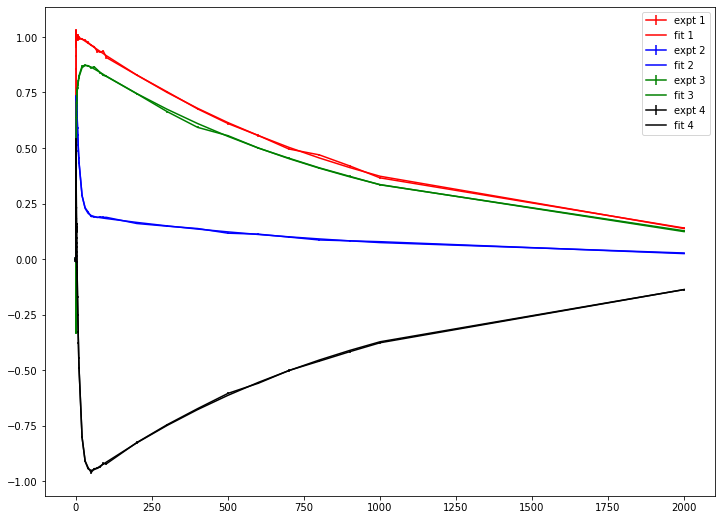

In [31]:
# plot fitting result and experimental data

color_lst = ['red', 'blue', 'green', 'black']

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.show()

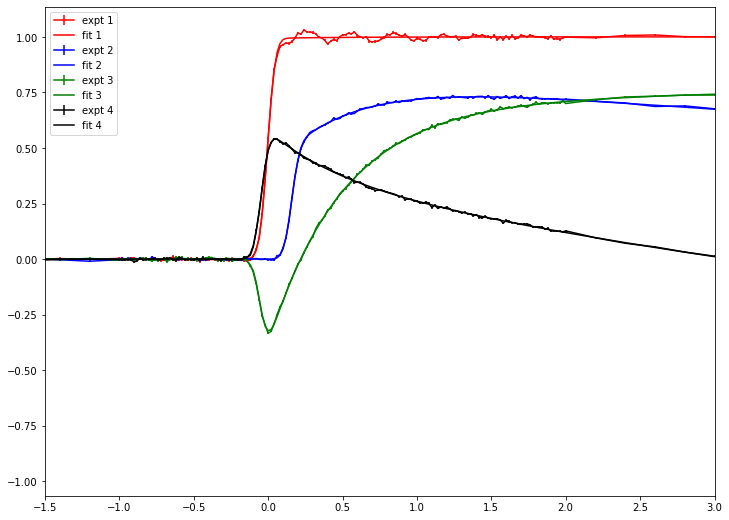

In [32]:
# plot with shorter time range

for i in range(4):
    plt.errorbar(t[0], intensity[0][:, i], eps[0][:, i], label=f'expt {i+1}', color=color_lst[i])
    plt.errorbar(t[0], fit_result_decay['fit'][0][:, i], label=f'fit {i+1}', color=color_lst[i])

plt.legend()
plt.xlim(-10*fwhm_init, 20*fwhm_init)
plt.show()


There may exists oscillation in experimental scan 1. To show oscillation feature plot residual (expt-fit)

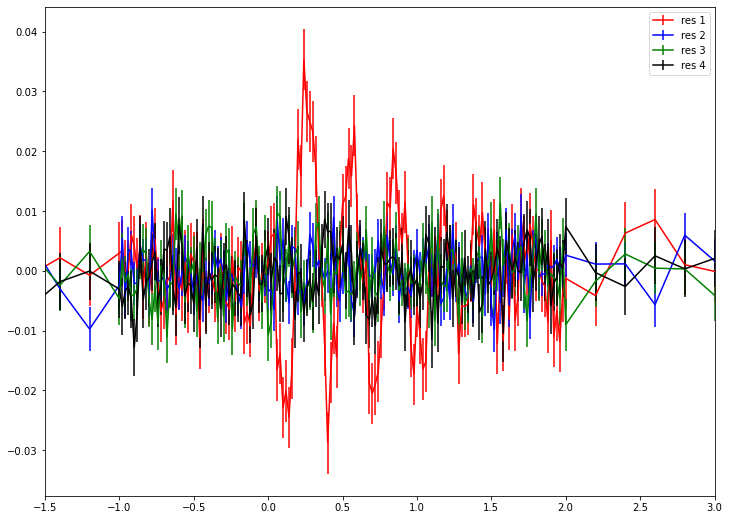

In [33]:
# To show oscillation feature plot residual
for i in range(4):
    plt.errorbar(t[0], fit_result_decay['res'][0][:, i], eps[0][:, i], label=f'res {i+1}', color=color_lst[i])

plt.legend()
plt.xlim(-10*fwhm_init, 20*fwhm_init)
plt.show()

Only residual for experimental scan 1 shows clear oscillation feature, Now add oscillation feature.

In [34]:
from TRXASprefitpack import fit_transient_both
tau_osc_init = np.array([1.5])
period_osc_init = np.array([0.5])

fit_result_decay_osc = fit_transient_both(irf, fwhm_init, t0_init, tau_init, 
tau_osc_init, period_osc_init,
False, method_glb='ampgo', kwargs_lsq={'verbose' : 2}, t=t, intensity=intensity, eps=eps)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9673e+02                                    4.01e-01    
       1              2         3.9673e+02      1.01e-06       2.04e-04       5.02e-02    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 3.9673e+02, final cost 3.9673e+02, first-order optimality 5.02e-02.


In [35]:
# print fitting result
print(fit_result_decay_osc)

[Model information]
    model : both
    irf: g
    fwhm:  0.0994
    eta:  0.0000
    base: False
 
[Optimization Method]
    global: ampgo
    leastsq: trf
 
[Optimization Status]
    nfev: 4098
    status: 0
    global_opt msg: Requested Number of global iteration is finished.
    leastsq_opt msg: `ftol` termination condition is satisfied.
 
[Optimization Results]
    Total Data points: 780
    Number of effective parameters: 30
    Degree of Freedom: 750
    Chi squared:  793.4582
    Reduced chi squared:  1.0579
    AIC (Akaike Information Criterion statistic):  73.3434
    BIC (Bayesian Information Criterion statistic):  213.1222
 
[Parameters]
    fwhm_G:  0.09942893 +/-  0.00073364 ( 0.74%)
    t_0_1_1: -0.00436417 +/-  0.00038112 ( 8.73%)
    t_0_1_2:  0.15745573 +/-  0.00050598 ( 0.32%)
    t_0_1_3: -0.05166261 +/-  0.00063012 ( 1.22%)
    t_0_1_4: -0.04598766 +/-  0.00054710 ( 1.19%)
    tau_1:  0.50061835 +/-  0.00194008 ( 0.39%)
    tau_2:  10.06476610 +/-  0.04045717 ( 0.

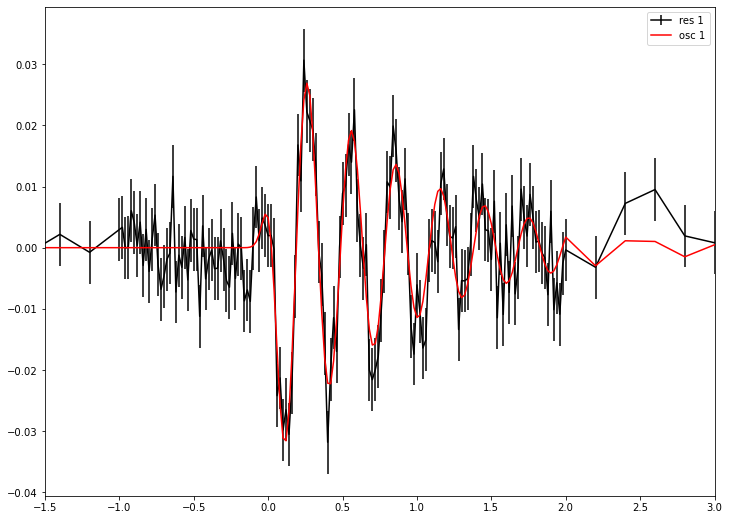

In [36]:
# plot residual and oscilation fit

for i in range(1):
    plt.errorbar(t[0], intensity[0][:, i]-fit_result_decay_osc['fit_decay'][0][:, i], eps[0][:, i], label=f'res {i+1}', color='black')
    plt.errorbar(t[0], fit_result_decay_osc['fit_osc'][0][:, i], label=f'osc {i+1}', color='red')

plt.legend()
plt.xlim(-10*fwhm_init, 20*fwhm_init)
plt.show()

print()



In [37]:
# Compare fitting value and exact value
for i in range(len(fit_result_decay_osc['x'])):
    print(f"{fit_result_decay_osc['param_name'][i]}: {fit_result_decay_osc['x'][i]} (fit) \t {param_exact[i]} (exact)")

fwhm_G: 0.09942893461280397 (fit) 	 0.1 (exact)
t_0_1_1: -0.004364170362199773 (fit) 	 -0.004960794315238031 (exact)
t_0_1_2: 0.157455725987222 (fit) 	 0.15689212316332068 (exact)
t_0_1_3: -0.051662610558068776 (fit) 	 -0.05307330175122729 (exact)
t_0_1_4: -0.04598765885010275 (fit) 	 -0.045460069698502054 (exact)
tau_1: 0.5006183545563633 (fit) 	 0.5 (exact)
tau_2: 10.064766102710598 (fit) 	 10 (exact)
tau_3: 1001.4802093272855 (fit) 	 1000 (exact)
tau_osc_1: 0.8770244895485201 (fit) 	 1 (exact)
period_osc_1: 0.29790060227720216 (fit) 	 0.3 (exact)


In [38]:
# save fitting result to file
from TRXASprefitpack import save_TransientResult, load_TransientResult

save_TransientResult(fit_result_decay_osc, 'example_decay_osc') # save fitting result to example_decay_2.h5
loaded_result = load_TransientResult('example_decay_osc') # load fitting result from example_decay_2.h5

Now deduce species associated difference coefficient from sequential decay model

In [39]:
y0 = np.array([1, 0, 0, 0]) # initial cond
eigval, V, c = solve_seq_model(loaded_result['x'][5:-2], y0)

# compute scaled V matrix
V_scale = np.einsum('j,ij->ij', c, V)
diff_abs_fit = np.linalg.solve(V_scale[:-1, :-1].T, loaded_result['c'][0][:-1,:]) 
# slice last column and row corresponding to ground state
# exclude oscillation factor

# compare with exact result
print('-'*24)
print('[Species Associated Difference Coefficent]')
print('scan # \t ex 1 (fit) \t ex 1 (exact) \t ex 2 (fit) \t ex 2 (exact) \t ex 3 (exact)')
print(f'1 \t {diff_abs_fit[0,0]} \t {abs_1[0]}  \t {diff_abs_fit[1,0]} \t {abs_1[1]} \t {diff_abs_fit[2,0]} \t {abs_1[2]}')
print(f'2 \t {diff_abs_fit[0,1]} \t {abs_2[0]}  \t {diff_abs_fit[1,1]} \t {abs_2[1]} \t {diff_abs_fit[2,1]} \t {abs_2[2]}')
print(f'3 \t {diff_abs_fit[0,2]} \t {abs_3[0]}  \t {diff_abs_fit[1,2]} \t {abs_3[1]} \t {diff_abs_fit[2,2]} \t {abs_3[2]}')
print(f'4 \t {diff_abs_fit[0,3]} \t {abs_4[0]}  \t {diff_abs_fit[1,3]} \t {abs_4[1]} \t {diff_abs_fit[2,3]} \t {abs_4[2]}')


------------------------
[Species Associated Difference Coefficent]
scan # 	 ex 1 (fit) 	 ex 1 (exact) 	 ex 2 (fit) 	 ex 2 (exact) 	 ex 3 (exact)
1 	 1.0016166620198441 	 1  	 0.9986909891212575 	 1 	 1.001358106266621 	 1
2 	 0.5014287754315223 	 0.5  	 0.7996731266907202 	 0.8 	 0.19931745207235022 	 0.2
3 	 -0.49838742783791146 	 -0.5  	 0.7007968038257401 	 0.7 	 0.8997625681399827 	 0.9
4 	 0.6007589231190612 	 0.6  	 0.2987208907068396 	 0.3 	 -0.9990377055850692 	 -1


It also matches well, as expected.

Now calculates `F-test` based confidence interval.

In [17]:
from TRXASprefitpack import confidence_interval

ci_result = confidence_interval(loaded_result, 0.05) # set significant level: 0.05 -> 95% confidence level
print(ci_result) # report confidence interval

[Report for Confidence Interval]
    Method: f
    Significance level:  5.000000e-02
 
[Confidence interval]
    0.09934728 -  0.0013406 <= fwhm_G <=  0.09934728 +  0.00135011
    0.04287779 -  0.00070775 <= t_0_1_1 <=  0.04287779 +  0.00071158
    0.06571111 -  0.00091867 <= t_0_1_2 <=  0.06571111 +  0.0009173
    -0.03062846 -  0.00114751 <= t_0_1_3 <= -0.03062846 +  0.0011475
    -0.07308943 -  0.00101283 <= t_0_1_4 <= -0.07308943 +  0.00100992
    0.49989437 -  0.00357168 <= tau_1 <=  0.49989437 +  0.00359769
    9.94396867 -  0.07179097 <= tau_2 <=  9.94396867 +  0.07248221
    999.77303556 -  6.61535874 <= tau_3 <=  999.77303556 +  6.67752365
    0.97567546 -  0.17879022 <= tau_osc_1 <=  0.97567546 +  0.24094418
    0.29895246 -  0.00329794 <= period_osc_1 <=  0.29895246 +  0.00326387


In [18]:
# compare with ase
from scipy.stats import norm

factor = norm.ppf(1-0.05/2)

print('[Confidence interval (from ASE)]')
for i in range(loaded_result['param_name'].size):
    print(f"{loaded_result['x'][i]: .8f} - {factor*loaded_result['x_eps'][i] :.8f}", 
          f"<= {loaded_result['param_name'][i]} <=", f"{loaded_result['x'][i] :.8f} + {factor*loaded_result['x_eps'][i]: .8f}")

[Confidence interval (from ASE)]
 0.09934728 - 0.00134839 <= fwhm_G <= 0.09934728 +  0.00134839
 0.04287779 - 0.00070060 <= t_0_1_1 <= 0.04287779 +  0.00070060
 0.06571111 - 0.00091885 <= t_0_1_2 <= 0.06571111 +  0.00091885
-0.03062846 - 0.00114879 <= t_0_1_3 <= -0.03062846 +  0.00114879
-0.07308943 - 0.00100681 <= t_0_1_4 <= -0.07308943 +  0.00100681
 0.49989437 - 0.00358743 <= tau_1 <= 0.49989437 +  0.00358743
 9.94396867 - 0.07309839 <= tau_2 <= 9.94396867 +  0.07309839
 999.77303556 - 6.63799029 <= tau_3 <= 999.77303556 +  6.63799029
 0.97567546 - 0.20313149 <= tau_osc_1 <= 0.97567546 +  0.20313149
 0.29895246 - 0.00317641 <= period_osc_1 <= 0.29895246 +  0.00317641


However, as you can see, in many case, ASE does not much different from more sophisticated `f-test` based error estimation.